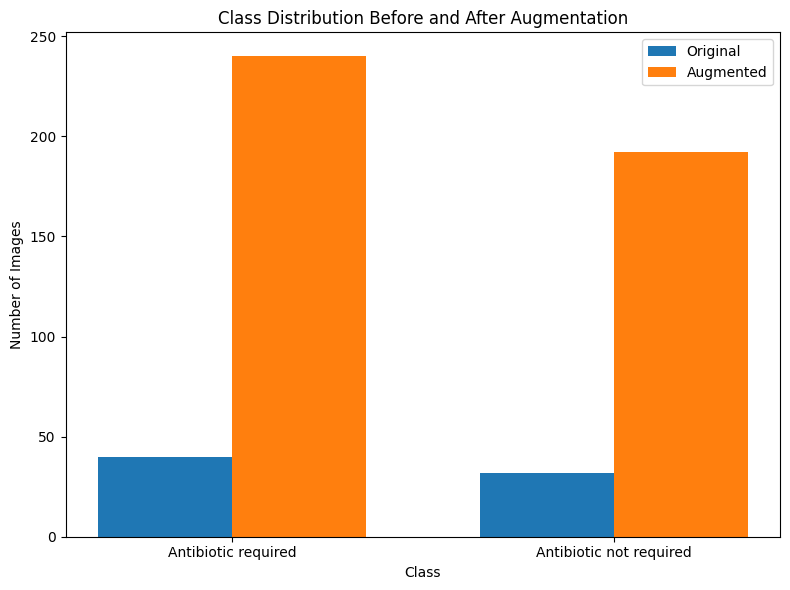

Augmentation complete. Augmented images are saved in the output directory.


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image

# Directories
input_dir = "antibiotic"  # Base directory containing 'Antibiotic required/' and 'Antibiotic not required/'
output_dir = "augmented_data"  # Directory to save augmented datasets

# Ensure output directories exist
categories = ["Antibiotic required", "Antibiotic not required"]
for category in categories:
    os.makedirs(os.path.join(output_dir, category), exist_ok=True)

# Define augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Load the dataset
original_dataset = ImageFolder(input_dir, transform=transforms.ToTensor())

# Count the number of images before augmentation
original_counts = [0, 0]
for _, label in original_dataset:
    original_counts[label] += 1

# Generate augmented images
def generate_augmented_images(dataset, num_augmented_images_per_image=5):
    augmented_counts = [0, 0]
    for idx, (image, label) in enumerate(dataset):
        category = categories[label]  # Get category name
        category_path = os.path.join(output_dir, category)  # Fix category path resolution
        for i in range(num_augmented_images_per_image):
            # Apply augmentations
            augmented_image = augmentation_transforms(image)
            save_path = os.path.join(category_path, f"img_{idx}_{i}.png")
            save_image(augmented_image, save_path)
            augmented_counts[label] += 1
    return augmented_counts

# Generate augmented datasets and get counts
augmented_counts = generate_augmented_images(original_dataset, num_augmented_images_per_image=5)

# Plot the bar chart before and after augmentation
def plot_class_distribution(original_counts, augmented_counts):
    x = categories
    original_values = original_counts
    augmented_values = [original_counts[i] + augmented_counts[i] for i in range(2)]

    # Create a bar chart
    width = 0.35  # Bar width
    x_axis = np.arange(len(x))  # Position of bars

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.bar(x_axis - width/2, original_values, width, label='Original')
    ax.bar(x_axis + width/2, augmented_values, width, label='Augmented')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution Before and After Augmentation')
    ax.set_xticks(x_axis)
    ax.set_xticklabels(x)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Plot the distributions
plot_class_distribution(original_counts, augmented_counts)

print("Augmentation complete. Augmented images are saved in the output directory.")


Class Mappings:
Class 0: Antibiotic not required
Class 1: Antibiotic required
Training set size: 290
Validation set size: 52
Testing set size: 18


C:\Users\patha\AppData\Local\Temp\ipykernel_24160\1526793618.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")
C:\Users\patha\AppData\Local\Temp\ipykernel_24160\1526793618.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")
C:\Users\patha\AppData\Local\Temp\ipykernel_24160\1526793618.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


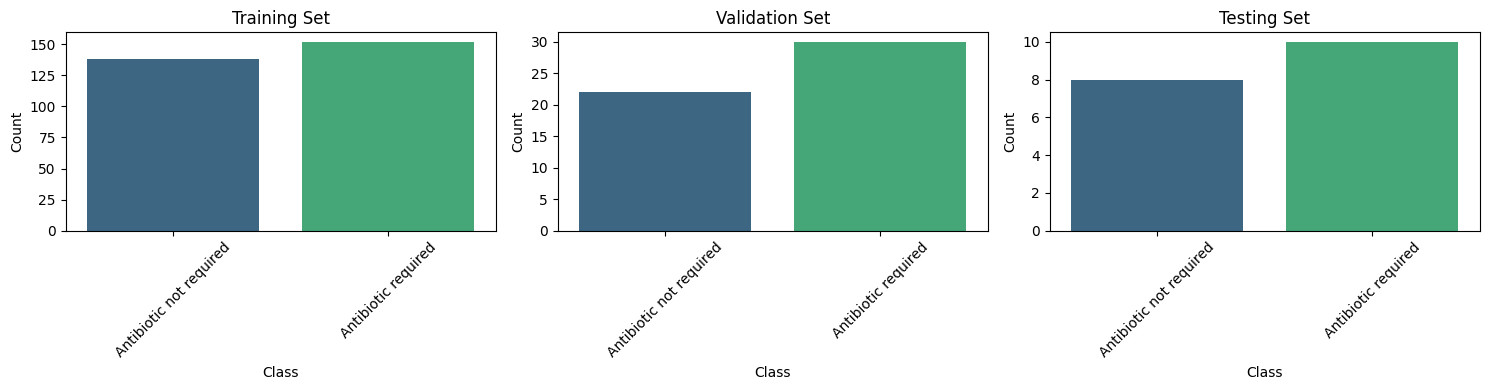

In [5]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to dataset
data_dir = "augmented_data"

# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir)

# Extract class names
class_names = dataset.classes

# Display class mapping
print("Class Mappings:")
for idx, class_name in enumerate(class_names):
    print(f"Class {idx}: {class_name}")

# Stratified splitting for train, validation, and test sets
targets = np.array(dataset.targets)

# Split into train and test
split_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
train_idx, test_idx = next(split_1.split(np.zeros(len(targets)), targets))

# Further split train into train and validation
split_2 = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_idx, val_idx = next(split_2.split(np.zeros(len(train_idx)), targets[train_idx]))

# Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Apply transforms
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val_test
test_dataset.dataset.transform = transform_val_test

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Verify the distribution
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

# Visualize class distribution with proper labels
def plot_class_distributions_with_mapping(train_dataset, val_dataset, test_dataset, class_names):
    datasets_info = [
        ("Training Set", train_dataset),
        ("Validation Set", val_dataset),
        ("Testing Set", test_dataset)
    ]

    plt.figure(figsize=(15, 4))
    
    for i, (title, dataset) in enumerate(datasets_info, start=1):
        classes, counts = np.unique([dataset.dataset.targets[idx] for idx in dataset.indices], return_counts=True)
        
        plt.subplot(1, 3, i)
        sns.barplot(x=classes, y=counts, palette="viridis")
        plt.title(title)
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.xticks(ticks=classes, labels=[class_names[cls] for cls in classes], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_class_distributions_with_mapping(train_dataset, val_dataset, test_dataset, class_names)


c:\Users\patha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25, Train Loss: 0.6564, Train Acc: 0.6036, Val Loss: 0.4702, Val Acc: 0.8163
Epoch 2/25, Train Loss: 0.3580, Train Acc: 0.8473, Val Loss: 0.6602, Val Acc: 0.7143
Epoch 3/25, Train Loss: 0.2874, Train Acc: 0.8764, Val Loss: 0.2839, Val Acc: 0.9184
Epoch 4/25, Train Loss: 0.2330, Train Acc: 0.9018, Val Loss: 0.2362, Val Acc: 0.9184
Epoch 5/25, Train Loss: 0.2093, Train Acc: 0.9127, Val Loss: 0.1482, Val Acc: 0.9592
Epoch 6/25, Train Loss: 0.1748, Train Acc: 0.9200, Val Loss: 0.1353, Val Acc: 0.9388
Epoch 7/25, Train Loss: 0.1694, Train Acc: 0.9345, Val Loss: 0.1369, Val Acc: 0.9592
Epoch 8/25, Train Loss: 0.1858, Train Acc: 0.9236, Val Loss: 0.2966, Val Acc: 0.8980
Epoch 9/25, Train Loss: 0.1568, Train Acc: 0.9527, Val Loss: 0.1574, Val Acc: 0.9184
Epoch 10/25, Train Loss: 0.2215, Train Acc: 0.9018, Val Loss: 0.1100, Val Acc: 0.9592
Epoch 11/25, Train Loss: 0.2261, Train Acc: 0.9055, Val Loss: 0.1484, Val Acc: 0.9388
Epoch 12/25, Train Loss: 0.1881, Train Acc: 0.9382, Val Loss: 0

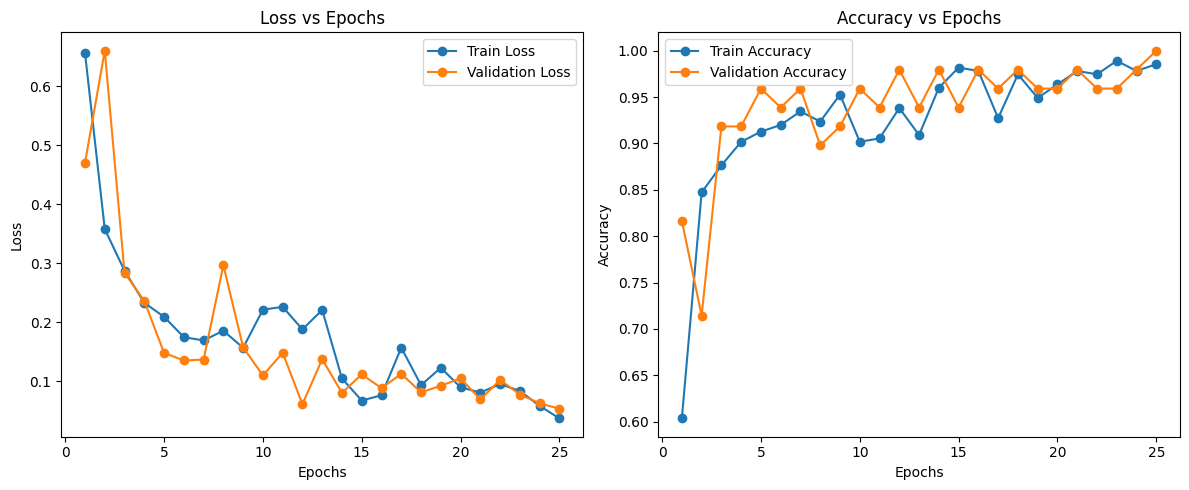

In [6]:

# Load ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze 50% of layers
num_layers = len(list(model.parameters()))
for i, param in enumerate(model.parameters()):
    if i < num_layers // 2:
        param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

model = model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += ((outputs > 0.5).float() == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += ((outputs > 0.5).float() == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

    # Plot accuracy and loss graphs
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25)




Test Accuracy: 1.0000


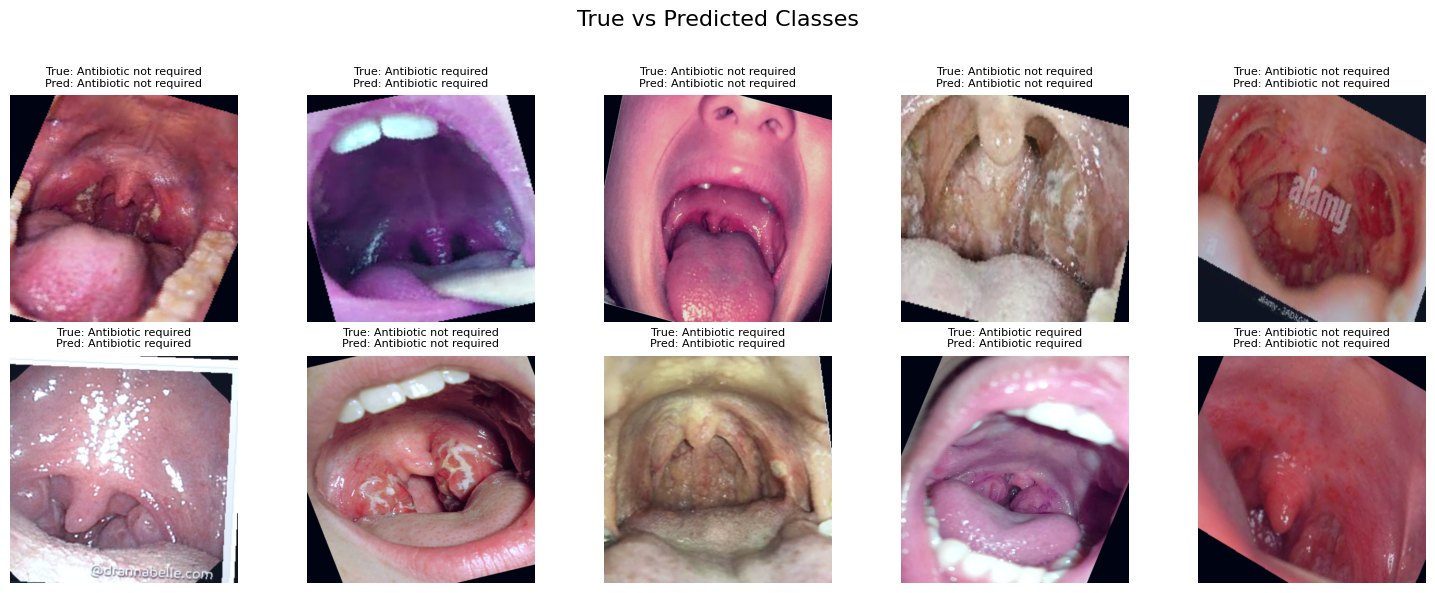

In [14]:
import random

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_images = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_images.extend(images.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Visualize true vs predicted classes with a random selection of 10 images
    indices = random.sample(range(len(all_images)), min(10, len(all_images)))
    selected_images = [all_images[i] for i in indices]
    selected_labels = [all_labels[i] for i in indices]
    selected_predictions = [all_predictions[i] for i in indices]

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle("True vs Predicted Classes", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(selected_images):
            image = np.transpose(selected_images[i], (1, 2, 0))
            image = np.clip(image * 0.229 + 0.485, 0, 1)  # De-normalize
            ax.imshow(image)
            true_label = "Antibiotic required" if selected_labels[i] == 1 else "Antibiotic not required"
            predicted_label = "Antibiotic required" if selected_predictions[i] == 1 else "Antibiotic not required"
            ax.set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=8)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


evaluate_model(model, test_loader)


In [20]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import plotly.graph_objects as go

def evaluate_model_with_roc_auc_interactive(model, test_loader):
    model.eval()
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)  # Get probabilities (sigmoid for binary classification)
            
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities).flatten()

    # Calculate ROC AUC score
    auc_score = roc_auc_score(all_labels, all_probabilities)
    print(f"ROC AUC Score: {auc_score:.4f}")

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)

    # Create an interactive ROC Curve plot using Plotly
    fig = go.Figure()

    # Plot ROC Curve
    fig.add_trace(go.Scatter(
        x=fpr, y=tpr, mode='lines', name=f'ROC Curve (AUC = {auc_score:.4f})',
        line=dict(color='blue', width=2)
    ))

    # Add diagonal line (random classifier line)
    fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier',
        line=dict(color='gray', dash='dash')
    ))

    # Add labels and title
    fig.update_layout(
        title="Receiver Operating Characteristic (ROC) Curve",
        xaxis=dict(title="False Positive Rate (FPR)", range=[0, 1]),
        yaxis=dict(title="True Positive Rate (TPR)", range=[0, 1]),
        showlegend=True
    )

    # Show the interactive plot
    fig.show()

# Assuming you already have the model and test_loader
evaluate_model_with_roc_auc_interactive(model, test_loader)


ROC AUC Score: 1.0000


Final Sensitivity: 100.00%
Final Specificity: 100.00%


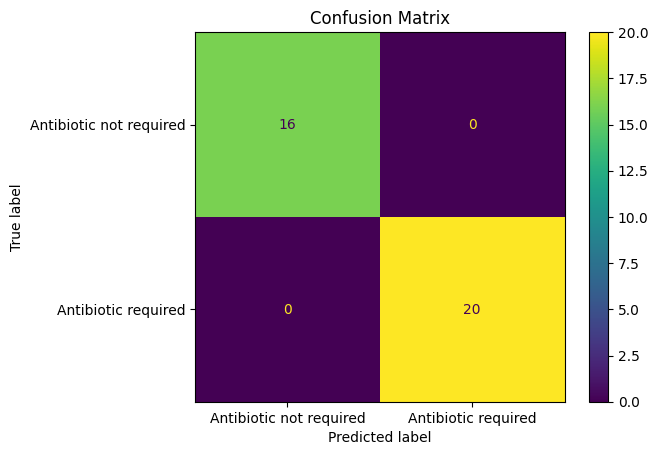

In [24]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def calculate_sensitivity_specificity(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Apply sigmoid and threshold at 0.5

            all_labels.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predictions.cpu().numpy().flatten())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])

    # Extract true positives (tp), false positives (fp), true negatives (tn), and false negatives (fn)
    tn, fp, fn, tp = cm.ravel()

    # Sensitivity and Specificity calculation
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Convert to percentage
    sensitivity_percent = sensitivity * 100
    specificity_percent = specificity * 100

    # Print sensitivity and specificity
    print(f"Final Sensitivity: {sensitivity_percent:.2f}%")
    print(f"Final Specificity: {specificity_percent:.2f}%")

    # Optionally, you can also plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Antibiotic not required", "Antibiotic required"])
    disp.plot(cmap="viridis", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Assuming you already have the model and test_loader
calculate_sensitivity_specificity(model, test_loader)
